## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [2]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

## Load training data

In [3]:
cars = glob.glob('vehicles/**/*.png')
noncars = glob.glob('non-vehicles/**/*.png')
print(len(cars), len(noncars))

8792 8968


## Hog

(64, 64, 3)


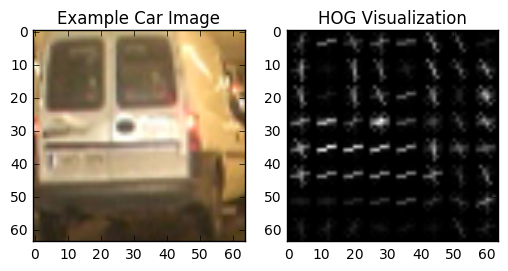

In [32]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
        return features

# Generate a random index to look at a car image
ind_car = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind_car])
print(image.shape)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

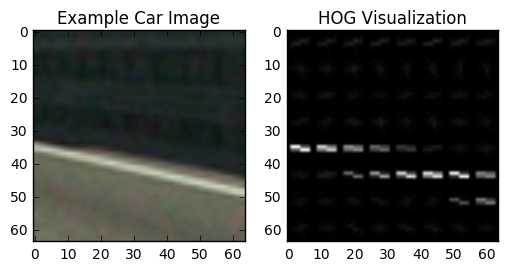

In [33]:
# Generate a random index to look at a car image
ind_noncar = np.random.randint(0, len(noncars))
# Read in the image
image = mpimg.imread(noncars[ind_noncar])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

## Extract

In [34]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    print(img)
    features = cv2.resize(img, size).ravel()
    #print(features)
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    #print(channel1_hist[0])
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [46]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    #print(len(imgs))
    # Iterate through the list of images
    for img in imgs:
        # Read in each one by one
        img = mpimg.imread(img) * 255
        print(img)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HLS':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HUV)
            if cspace == 'YUV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            if cspace == 'HSV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            if cspace == 'LSV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2LSV)
        else:
            feature_img = np.copy(img)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_img, spatial_size)
        # Apply color_hist() to get color histogram features
        hist_features = color_hist(feature_img, nbins=hist_bins, bins_range=hist_range)
        #print(hist_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

#print(cars)
car_features = extract_features(cars[:2], cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
#print(len(car_features))
#print(car_features)
notcar_features = extract_features(noncars[:2], cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

#print(len(notcar_features))

[[[ 156.  168.  163.]
  [ 156.  168.  163.]
  [ 156.  167.  162.]
  ..., 
  [ 100.  112.   90.]
  [ 102.  113.   91.]
  [ 103.  113.   91.]]

 [[ 156.  168.  163.]
  [ 156.  168.  163.]
  [ 156.  167.  162.]
  ..., 
  [ 100.  112.   90.]
  [ 102.  113.   91.]
  [ 103.  113.   91.]]

 [[ 156.  167.  161.]
  [ 156.  167.  161.]
  [ 156.  166.  160.]
  ..., 
  [ 100.  113.   90.]
  [ 102.  114.   92.]
  [ 103.  114.   92.]]

 ..., 
 [[ 123.  128.  115.]
  [ 123.  128.  115.]
  [ 123.  127.  114.]
  ..., 
  [ 159.  159.  141.]
  [ 159.  159.  140.]
  [ 159.  159.  140.]]

 [[ 122.  127.  114.]
  [ 122.  127.  114.]
  [ 122.  126.  113.]
  ..., 
  [ 159.  159.  141.]
  [ 161.  161.  142.]
  [ 161.  161.  142.]]

 [[ 122.  127.  114.]
  [ 122.  127.  114.]
  [ 122.  126.  113.]
  ..., 
  [ 159.  159.  140.]
  [ 161.  161.  142.]
  [ 161.  161.  142.]]]
[[[ 156.  168.  163.]
  [ 156.  168.  163.]
  [ 156.  167.  162.]
  ..., 
  [ 100.  112.   90.]
  [ 102.  113.   91.]
  [ 103.  113.   91.]]


(4, 3168)
[ 109.    103.25   97.   ...,    0.      0.      0.  ]
[-1.20965789 -1.62659118 -1.72230391 ...,  0.          0.          0.        ]


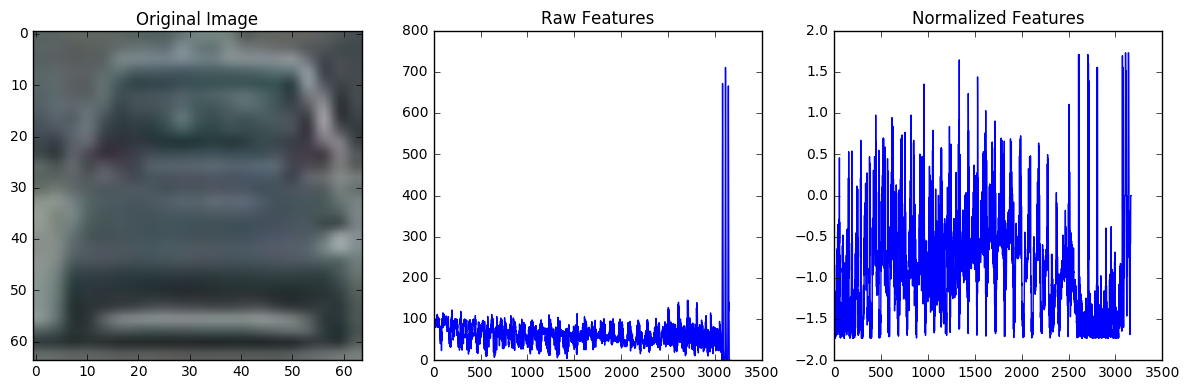

In [47]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    print(X.shape)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, 2)
    car_ind = 3
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    print(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    print(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')